In [7]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
sys.path.append('harbour-space-text-mining-course')

from tmcourse.ipyquiz import Quiz

from tmcourse.utils import (
    enable_mathjax_in_cell,
    display_cv_results,
    display_token_importance,
)
from tmcourse.quiz import (
    quiz_pipeline_parameter,
)

from tmcourse.demo import (
    demo_gradient_descent,
)
import numpy as np
from collections import Counter
from math import exp
from tabulate import tabulate
from tqdm.notebook import tqdm
from IPython.display import HTML, display

Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 436 (delta 88), reused 84 (delta 45), pack-reused 307
Receiving objects: 100% (436/436), 40.48 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (271/271), done.


<!--@slideshow slide-->
<center><h1>Text classification</h1></center>

<!--@slideshow slide-->
# Machine Learning basics refresher

<!--@slideshow slide-->
## What is Machine Learning?
![Machine Learning vs. Computer Science](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ml_vs_cs.png)

<!--@slideshow slide-->
## Definitions
- We have _data_ about $N$ _objects_ ($1, 2, \dots, N$).
- Each object $n$ has _features_ $\mathbf{x}_n$: a list of numbers.
- Each object $n$ has _label_ $y_n$: a number (integer or real number).



<!--@slideshow fragment-->
In the context of Text Mining:
  - Object: a text.
  - Features: the vector of TF-IDFs.
  - Label: the category of the text (integer).


<!--@slideshow fragment-->
Notation:
- We store features $\mathbf{x}_n$ in a matrix $\mathbf{X}$.
- We store labels $y_n$ in a vector $\mathbf{y}$.

<!--@slideshow slide-->
## Machine Learning Algorithm (informally)

- Input: data $\mathbf{X}, \mathbf{y}$ about objects $1, 2, \dots, N$.
- Output: _rules_ that predict answers on **new similar** objects.

> Usually, rules are called **models**.

<!--@slideshow fragment-->
Example: least squares.

Assumption: $y_n \approx a x_n + b$ for some $a, b$.

The rule (the model): for given $x$, muptiply by $a$ and add $b$.

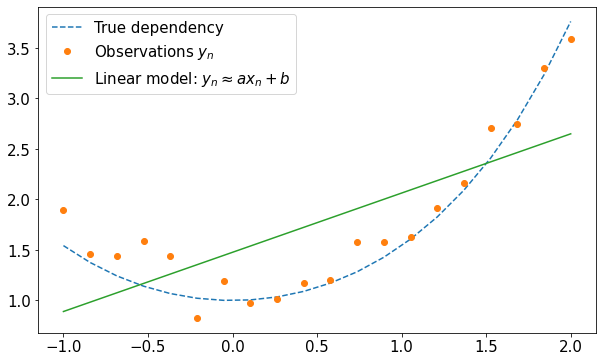

In [2]:
#@slideshow slide tags=remove_input
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})

np.random.seed(0)
x = np.linspace(-1, 2, 20)
y_true = np.cosh(x)
y = y_true + np.random.randn(x.shape[0]) * 0.2
linear_approximation = np.poly1d(np.polyfit(x, y, 1))
plt.figure(figsize=(10, 6))
plt.plot(
    x, y_true, '--',
    x, y, 'o',
    x, linear_approximation(x), '-'
)
plt.legend([
    r"True dependency",
    r"Observations $y_n$",
    r"Linear model: $y_n \approx a x_n + b$"])
plt.show()

<!--@slideshow slide-->
## Linear models

A _linear model_ is the Machine Learning algorithm that predicts $y_i$ using a linear function of features $w_0 + \sum_j w_j x_{ij}$.



<!--@slideshow fragment-->
Coefficients $w_0, w_1, \dots$ are called _parameters_. They can be written as a vector $\mathbf{w} = (w_0, w_1, \dots)$.



<!--@slideshow fragment-->
Even for one-dimensional data $x$, we can have many features: $x, x^2, x^3, \dots, x^d$ and the corresponding weights.

The number $d$ (the degree of polynomial) is a _hyperparameter_. It should be set before training.

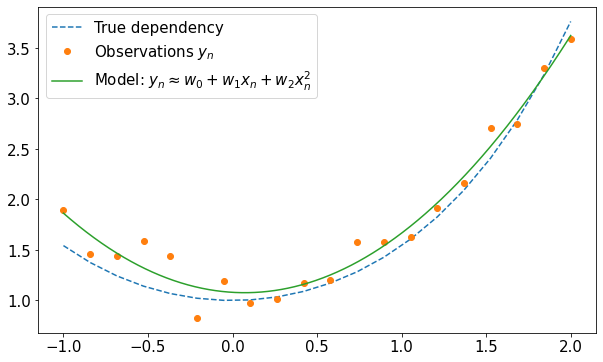

In [3]:
#@slideshow slide tags=remove_input
np.random.seed(0)
x_min = -1
x_max = 2
x = np.linspace(x_min, x_max, 20)
y_true = np.cosh(x)
y = y_true + np.random.randn(x.shape[0]) * 0.2
approximation_2 = np.poly1d(np.polyfit(x, y, 2))
x_precise = np.linspace(x_min, x_max, 1000)
plt.figure(figsize=(10, 6))
plt.plot(
    x, y_true, '--',
    x, y, 'o',
    x_precise, approximation_2(x_precise), '-'
)
plt.legend([
    r"True dependency",
    r"Observations $y_n$",
    r"Model: $y_n \approx w_0 + w_1 x_n + w_2 x_n^2$"
])
plt.show()

<!--@slideshow slide-->
## Loss functions and gradient descent


<!--@slideshow fragment-->
How to choose parameters $w_0, w_1, \dots$ of the linear model $h(x)$?


<!--@slideshow fragment-->
We need to measure how well the model $h(x)$ describes the data.


<!--@slideshow fragment-->
We can compute the error for each object. For example
$$
\ell(x_n, y_n) = \frac{1}{2}(y_n-h(x_n))^2
$$


<!--@slideshow fragment-->
The average error is called _loss function_. For example, this is Mean Squared Error:
$$
L(\mathbf{X}, \mathbf{y}, h) = \dfrac{1}{N}\sum_{1 \leq n \leq N}\frac{1}{2}(y_n-h(x_n))^2
$$


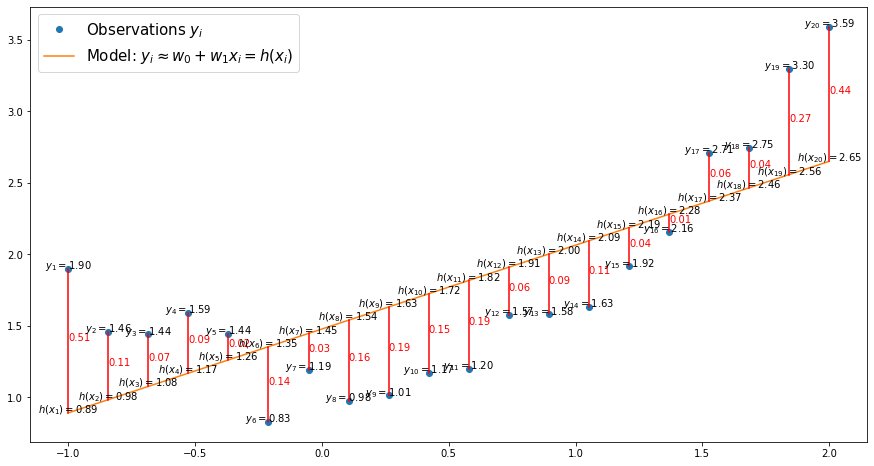

In [4]:
#@slideshow slide tags=remove_input

plt.rcParams.update({'font.size': 10})
x_smooth = np.linspace(-1, 2, 500)
h1 = linear_approximation

plt.figure(figsize=(15, 8))
plt.plot(x, y, 'o', x_smooth, h1(x_smooth))
losses = []
for i, item in enumerate(zip(x, y)):
    n = i+1
    xi, yi = item
    l = 0.5 * (yi - h1(xi))**2
    losses.append(l)
    plt.plot([xi, xi], [yi, h1(xi)], c="r")
    plt.annotate(r"$y_{{{}}} = {:.2f}$".format(n, yi), (xi, yi), ha='center')
    plt.annotate(r"$h(x_{{{}}}) = {:.2f}$".format(n, h1(xi)), (xi, h1(xi)), ha='center')
    plt.annotate("{:.2f}".format(l), (xi, 0.5*(yi + h1(xi))), c="r")

plt.rcParams.update({'font.size': 15})
plt.legend(
    [
        r"Observations $y_i$",
        r"Model: $y_i \approx w_0 + w_1 x_i = h(x_i)$"
    ]
)

plt.show()

enable_mathjax_in_cell()
display(
    HTML(
        r"$L(\mathbf{X}, \mathbf{y}, h) = \dfrac{1}{N}\sum_{1 \leq n \leq N}\frac{1}{2}(y_n-h(x_n))^2=" + r"{:.2f}$".format(np.mean(losses))
    )
)

<!--@slideshow slide-->
Loss function $L(\mathbf{X}, \mathbf{y}, h)$ depends on parameters of the linear model $\mathbf{w} = w_0, w_1, \dots$.

So we can minimize it w.r.t. $\mathbf{w}$.


<!--@slideshow fragment-->
We can do it using _gradient descent_.

**Idea**: if we slightly change the parameters by $\Delta \mathbf{w} = (\Delta w_0, \Delta w_1, \dots)$, then
$$
\Delta L \approx \dfrac{\partial L}{\partial w_0}\Delta w_0 + \dfrac{\partial L}{\partial w_1}\Delta w_1 + \dots = \nabla L \cdot \Delta \mathbf{w}
$$
where $\nabla L$ is the _gradient_.

We want $\Delta L < 0$ (since we are minimizing $L$), so $\nabla L \cdot \Delta \mathbf{w} < 0$.

It means that we should take the step $\Delta \mathbf{w}$ in the direction _opposite_ to the gradient (hence the name "gradient _descent_").


<!--@slideshow slide-->
There are two versions of gradient descent:
- _Full gradent descent_: minimization of the total sum $\dfrac{1}{N}\sum_{1 \leq n \leq N}\frac{1}{2}(y_n-h(x_n))^2$.
- _Stochastic gradient descent_: iterate over objects randomly and for each iteration minimize $\frac{1}{2}(y_n-h(x_n))^2$.

<!--@slideshow slide-->
## Colab demo: gradient descent

In [5]:
demo_gradient_descent(lambda x: x**4 - x**3 - x**2 + 1, theta_0=-1, learning_rate=0.5)  # local minima

In [6]:
demo_gradient_descent(lambda x: x**2, theta_0=-1, learning_rate=0.5)  # divergence

<!--@slideshow slide-->
## Overfitting and cross-validation

A Machine Learning Algorithm may fit the training data too closely, like this polynomial of degree 15:

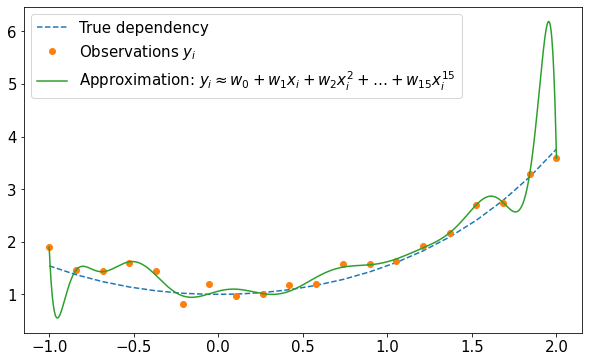

In [7]:
#@slideshow fragment tags=remove_input
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x_min = -1
x_max = 2
x = np.linspace(x_min, x_max, 20)
y_true = np.cosh(x)
y = y_true + np.random.randn(x.shape[0]) * 0.2
approximation = np.poly1d(np.polyfit(x, y, 15))
x_precise = np.linspace(x_min, x_max, 1000)
plt.figure(figsize=(10, 6))
plt.plot(
    x, y_true, '--',
    x, y, 'o',
    x_precise, approximation(x_precise), '-'
)
plt.legend([
    r"True dependency",
    r"Observations $y_i$",
    r"Approximation: $y_i \approx w_0 + w_1 x_i + w_2 x_i^2 + \dots + w_{15} x_i^{15}$"])
plt.show()

<!--@slideshow fragment-->
Such an algorithm will unlikely predict well on new data.

<!--@slideshow slide-->
**Idea**: pretend that we actually have "new" data.
- Split the data into two parts: training and validation.
- Train on the training part
- Compute the loss function $L$ on the validation part.
- Repeat $k$ times for different _folds_ (see the picture).

This is called _$k$-fold cross-validation_.

![alt text](https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg)

<!--@slideshow slide-->
## Logistic regression

So far we discussed real-valued labels (regression). What if labels are discrete (classification)?

<!--@slideshow fragment-->

Example: binary classification (classes 0 and 1).

Predict probability of class 1: $\Pr(1 | \mathbf{x}_n) = \sigma(w_0 + w_1 x_{n1} + w_2 x_{n2} + \dots)$

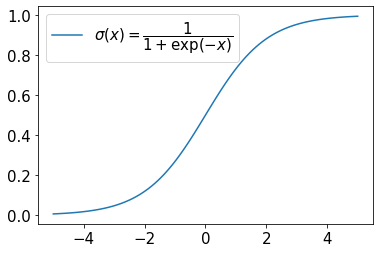

In [8]:
#@slideshow fragment tags=remove_input
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)
plt.plot(x, 1 / (1 + np.exp(-x)))

plt.legend([r"$\sigma(x) = \dfrac{1}{1 + \exp(-x)}$",])
plt.show()

<!--@slideshow slide-->
Loss function: negative log-likelihood (maximize likelihood $\Longleftrightarrow$ minimize negative log-likelihood)
$$
L(\mathbf{X}, \mathbf{y}, h) = -\dfrac{1}{N}\sum_{1 \leq n \leq N} \log\left( \Pr(1|\mathbf{x}_n)^{y_n} \cdot (1 - \Pr(1|\mathbf{x}_n))^{1 - y_n} \right)
$$

Minimize the loss function using _stochastic gradient descent_.

<!--@slideshow slide-->
# Colab demo: 20 newsgroups

## Get the data
- We work with 4 categories instead of 20 to speed up the demonstration
- We remove metadata because it may contain true labels

In [51]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(
    subset="all",
    remove=('headers', 'footers', 'quotes'),
    categories=("sci.space", "rec.autos", "talk.politics.misc", "comp.graphics")
)

texts = dataset.data
y = dataset.target

# look at the data
from pprint import pprint
pprint(texts[0])
print("Label:", y[0])
print("Category:", dataset.target_names[y[0]])

('Forwarded from Doug Griffith, Magellan Project Manager\n'
 '\n'
 '                        MAGELLAN STATUS REPORT\n'
 '                            April 16, 1993\n'
 '\n'
 '1.  The Magellan mission at Venus continues normally, gathering gravity\n'
 'data which provides measurement of density variations in the upper\n'
 'mantle which can be correlated to surface topography.  Spacecraft\n'
 'performance is nominal.\n'
 '\n'
 '2.  Magellan has completed 7225 orbits of Venus and is now 39 days from\n'
 'the end of Cycle-4 and the start of the Transition Experiment.\n'
 '\n'
 '3.  No significant activities are expected next week, as preparations\n'
 'for aerobraking continue on schedule.')
Label: 2
Category: sci.space


## Split into train and test

To split the data into training and testing parts, use `sklearn.model_selection.train_test_split`.
The important parameters:
- `shuffle`: is `True` by default.
- `random_state` (integer): always set it to have reproducible results!
- `test_size`: ratio of samples in the testing part.

In [52]:
# the example of train_test_split
# it works with any number of arrays of any types
from sklearn.model_selection import train_test_split
data1 = [1, 2, 3, 4, 5, 6]
data2 = list("abcdef")
data3 = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
train_data1, test_data1, train_data2, test_data2, train_data3, test_data3 = \
    train_test_split(data1, data2, data3, test_size=0.5, random_state=1)
print("Training parts:", train_data1, train_data2, train_data3)
print("Testing parts:", test_data1, test_data2, test_data3)

Training parts: [1, 4, 6] ['a', 'd', 'f'] [1.0, 4.0, 6.0]
Testing parts: [3, 2, 5] ['c', 'b', 'e'] [3.0, 2.0, 5.0]


In [0]:
# split texts and labels into train and test
texts_train, texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.5, random_state=1)

## Convert texts to vectors
Use `TfidfVectorizer` to convert texts into vectors
- First `fit()` it on the training data.
- Then `transform()` both training and testing data.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
vec.fit(texts_train)
X_train = vec.transform(texts_train)
X_test = vec.transform(texts_test)

## Train the classifier
We use `SGDClassifier`:
- `loss="log"` means that we train Logistic Regression
- `alpha=0.0001` is the learning rate of stochastic gradient descent
- `max_iter=50` is the maximum number of passes over the training data
- `random_state=0` is the random seed for shuffling

In [55]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(alpha=.0001, max_iter=50, loss="log", random_state=0)

clf.fit(X_train, y_train)
from sklearn.metrics import accuracy_score
print("Accuracy on train:", accuracy_score(y_train, clf.predict(X_train)))

Accuracy on train: 0.9806659505907627


## Estimate accuracy using cross-validation
To perform cross-validation, we use `sklearn.model_selection.cross_val_score`.
- It accepts the classifier object, the matrix of features $X$ and the vector of labels $y$.
- The parameter `cv=3` means that we use 3-fold cross-validation.
- The `cross_val_score` function automatically split the data (both $X$ and $y$) into folds, trains the classifier and computes its quality. By default, for classifiers accuracy is computed.

In [56]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(clf, X_train, y_train, cv=3)
import numpy as np
print(f"cv_scores: {cv_scores}")
print("Average accuracy on cross-validaion:", np.mean(cv_scores))

cv_scores: [0.85024155 0.86312399 0.83548387]
Average accuracy on cross-validaion: 0.8496164701400793


## Combine everything into pipeline
For now, we have to train the classifier in two steps:
- First, vectorize the texts and get the matrix $X$.
- After that, use this matrix for classification.

It is convenient to combine these steps into so-called _Pipeline_ (not to be confused with NLP pipeline from the Lecture 1!).

`sklearn.pipeline.Pipeline` allows to create a chain of vectorizers and classifiers.

In [57]:
from sklearn.pipeline import Pipeline

# a Pipeline is created from the list of 2-tuples
# each tuple has the name ("vec" or "clf") and the corresponding class
pipeline = Pipeline([
    ("vec", vec),
    ("clf", clf),
])

# pipeline.fit(texts_train, y_train) performs the following computations:
# 1) vec.fit(texts_train)
# 2) X_train = vec.transform(texts_train)
# 3) clf.fit(X_train, y_train)
pipeline.fit(texts_train, y_train)
print("Accuracy on train:", accuracy_score(y_train, pipeline.predict(texts_train)))

cv_scores = cross_val_score(pipeline, texts_train, y_train, cv=3)
print("Average accuracy on cross-validaion:", np.mean(cv_scores))

Accuracy on train: 0.9806659505907627
Average accuracy on cross-validaion: 0.8506908732013921


## Choose the best parameters for pipeline
The advantage of pipelines is that we can select best parameters (using cross-validation) for both vectorizer and classifier.

In [58]:
from sklearn.model_selection import GridSearchCV

# This is where we need the names of stages in the pipeline: "vec" and "clf"
# We will try different parameters for both vectorizer and classifier
param_grid = {
    "vec__stop_words": [None, "english"],
    "vec__ngram_range": [(1, 1), (1, 2)],
    "clf__alpha": [1e-4, 1e-3, 1e-2],
}

# GridSearchCV does the following
#  1) It computes all possible combinations of parameters from `param_grid`
#  2) For each combination of parameters, perform k-fold cross-validation (k=3 in our case)
#  3) Choose parameters that give the highest accuracy on cross-validation
pipeline_grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3)
pipeline_grid_search.fit(texts_train, y_train)

# The function `display_cv_results` is not a sklearn function
# I implemented it for your convenience
display_cv_results(pipeline_grid_search)

,mean_test_score,param_clf__alpha,param_vec__ngram_range,param_vec__stop_words
0,0.867880,0.0001,"(1, 1)",english
1,0.865732,0.0001,"(1, 2)",english
2,0.857678,0.001,"(1, 2)",english
3,0.857673,0.001,"(1, 1)",english
4,0.850691,0.0001,"(1, 1)",None
5,0.837804,0.0001,"(1, 2)",None
6,0.825452,0.001,"(1, 1)",None
7,0.803977,0.001,"(1, 2)",None
8,0.747596,0.01,"(1, 1)",english
9,0.725026,0.01,"(1, 1)",None


## Evaluate accuracy on test

**After** we have chosen the best parameters for both vectorizer and classifier, we can compute the accuracy on the testing data.

**NB!** If you compute accuracy on the testing data _many_ times, you overfit on the testing data. **Always make decisions based on cross-validation.**

![alt text](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [59]:
accuracy_score(y_test, pipeline_grid_search.predict(texts_test))

0.8727858293075684

As we can see, the final accuracy on test is close to the accuracy on cross-validation. It is a good sign: no overfitting, and the accuracy is quite high.

## Find important tokens

**Idea**: a token is important, if its _removal_ significantly changes predictions.

In [62]:
def compute_token_importance(clf, text):
    from scipy.linalg import norm
    # a simple tokenizer: split by whitespace
    # not necessarily the same tokenizer that the vectorizer uses!
    import re
    tokens = re.split(r'\W+', text.strip())
    initial_text = " ".join(tokens)
    # predict the probabilities of all classes for the initial text
    initial_class_distribution = clf.predict_proba([initial_text])[0]
    # print(initial_class_distribution, type(initial_class_distribution))
    token_importances = []
    for i, token in enumerate(tokens):
        masked_tokens = tokens[:]
        # mask (remove) one token
        masked_tokens[i] = "<UNKNOWN>"
        masked_text = " ".join(masked_tokens)
        # classify the text with masked token
        masked_class_distribution = clf.predict_proba([masked_text])[0]
        print(masked_class_distribution, type(masked_class_distribution))
        # token importance is the distance between
        # the initial distribution of classes
        # and the distribution after removal of the token
        token_importance = norm(initial_class_distribution - masked_class_distribution)
        token_importances.append((token, token_importance))
    return token_importances

# remember the initial categories in the dataset
print("categories:", ", ".join(dataset.target_names))
for text, label in zip(texts_train[:1], y_train[:1]):
    display(HTML("<hr>"))
    # display(HTML(dataset.target_names[label]))  # uncomment this line to see the true label
    token_importances = compute_token_importance(pipeline_grid_search, text)
    display_token_importance(token_importances)
    display(HTML("<hr>"))

categories: comp.graphics, rec.autos, sci.space, talk.politics.misc


[0.09883224 0.10608106 0.71411323 0.08097346] <class 'numpy.ndarray'>
[0.09196839 0.11423883 0.71029479 0.08349798] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.0913303  0.09971192 0.72971229 0.07924549] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.10548619 0.0965007  0.72320997 0.07480314] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.10274349 0.11446217 0.71047375 0.07232059] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.10179177 0.10503029 0.71579761 0.07738033] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.09806404 0.10854365 0.71229053 0.08110178] <class 'numpy.ndarray'>
[0.09847194 0.10762509 0.71396434 0.07993863] <class 'numpy.ndarray'>
[0.07842062 0.11616372 0.72158824 0.08382741] <class 'numpy.ndarray'>
[0.09847194 0.107625

# Coding session

## Get the data

In [0]:
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/content_classification.csv", header=0, names=["text", "label"])

## Exercise 1. Preliminary analysis
1. How many texts?
2. How many distinct labels?

In [30]:
# YOUR CODE HERE
print(df.shape)
print("# of labels: ", len(df.groupby("label")))
df.groupby("label").count()

(12663, 2)
# of labels:  7


,text
label,
achievement,3931
affection,4338
bonding,1583
enjoy_the_moment,1380
exercise,196
leisure,986
nature,249


## Exercise 2. Get numeric labels

In this dataset, each text has a human-readable label instead of numeric label. You need to convert the labels into a vector of numbers (the vector $y$ in our notation). Use `sklearn.preprocessing.LabelEncoder` (see the example below).

In [31]:
# example of LabelEncoder usage
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
print(f"le.classes_: {le.classes_}")
print(le.transform(["tokyo", "tokyo", "paris"]))
print(list(le.inverse_transform([2, 2, 1])))

le.classes_: ['amsterdam' 'paris' 'tokyo']
[2 2 1]
['tokyo', 'tokyo', 'paris']


In [32]:
from sklearn.preprocessing import LabelEncoder

# YOUR CODE HERE: create label encoder
le = LabelEncoder()
# YOUR CODE HERE: fit label encoder
le.fit(df.label)
# YOUR CODE HERE: transform the labels
y = le.transform(df.label)
print(y[:5])

[5 1 2 2 5]


## Exercise 3. Split into train and test
Use `sklearn.model_selection.train_test_split` with parameters `random_state=1` and `test_size=0.25`.

In [33]:
from sklearn.model_selection import train_test_split
# YOUR CODE HERE: split into train/test
texts_train, texts_test, y_train, y_test = train_test_split(df.text, y, test_size=0.25, random_state=1)
texts_train.shape, texts_test.shape, y_train.shape, y_test.shape

((9497,), (3166,), (9497,), (3166,))

## Exercise 4. Train and evaluate sklearn.pipeline.Pipeline

- Combine `TfidfVectorizer` and `SGDClassifier` into `Pipeline`.
- For `SGDClassifier`, use `alpha=.001, max_iter=50, loss="log", random_state=0`
- Use `cv=3` for cross-val score

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# YOUR CODE HERE: create Pipeline
vec = TfidfVectorizer()
clf = SGDClassifier(loss="log")
pipeline = Pipeline([
    ("vec", vec),
    ("clf", clf),
])

# YOUR CODE HERE: compute cv_scores using cross_val_score
cv_scores = cross_val_score(pipeline, texts_train, y_train, cv=3)
import numpy as np
print("Average accuracy on cross-validaion:", np.mean(cv_scores))

Average accuracy on cross-validaion: 0.8002525184482175


## Exercise 5. Choose the best parameters of the pipeline
- Use `cv=3` for `GridSearchCV`
- For the vectorizer, try `stop_words=None` and `stop_words="english"`.
- For the vectorizer, try `ngram_range=(1, 1)` and `ngram_range=(1, 2)`.
- For the classifier, try `alpha=1e-4`, `alpha=1e-3` and `alpha=1e-2`
- Compute `cross_val_score` for the pipeline found by `GridSearchCV`. Is it different from the `cross_val_score` from the Exercise 4?

In [38]:
from sklearn.model_selection import GridSearchCV

# YOUR CODE HERE: define the grid for all the parameters
param_grid = {
    "vec__stop_words": [None, "english"],
    "vec__ngram_range": [(1, 1), (1, 2)],
    "clf__alpha": [1e-4, 1e-5]
  }
# YOUR CODE HERE: choose the best pipeline using GridSearchCV
pipeline_grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3)
# YOUR CODE HERE: fit the pipeline
pipeline_grid_search.fit(texts_train, y_train)

display_cv_results(pipeline_grid_search)
cv_scores = cross_val_score(pipeline_grid_search, texts_train, y_train, cv=3)
print("Average accuracy on cross-validaion:", np.mean(cv_scores))

,mean_test_score,param_clf__alpha,param_vec__ngram_range,param_vec__stop_words
0,0.817416,1e-05,"(1, 2)",None
1,0.812467,1e-05,"(1, 1)",None
2,0.802780,1e-05,"(1, 2)",english
3,0.800147,0.0001,"(1, 1)",None
4,0.798147,1e-05,"(1, 1)",english
5,0.791829,0.0001,"(1, 1)",english
6,0.787512,0.0001,"(1, 2)",None
7,0.771823,0.0001,"(1, 2)",english


Average accuracy on cross-validaion: 0.8197328314233944


In [0]:
pipeline_grid_search.get_params()

## Exercise 6. Evaluate accuracy on test
Compare the accuracy on test with the accuracy estimated by `cross_val_score` in Exercise 5. Are they close to each other? Is it good?

In [43]:
# YOUR CODE HERE: compute the accuracy on test
accuracy_score(y_test, pipeline_grid_search.predict(texts_test))

0.8196462413139608

## Exercise 7. Find important tokens
- Look at the important tokens for the first 10-20 texts of the test datasets. Do they correspond to the true labels?
- Use the method `.inverse_transform()` of `LabelEncoder` to get label name from the numeric value

In [0]:
for text, label in zip(texts_test[:20], y_test[:20]):
    # print(type(label))
    display(HTML("<hr>"))
    # YOUR CODE HERE: get the human-readable label
    # label = label.tolist()
    # print(type(label))
    true_label = le.inverse_transform([label])
    display(HTML(true_label[0]))
    # YOUR CODE HERE: compute token inportances
    token_importances = compute_token_importance(pipeline_grid_search, text)
    display_token_importance(token_importances)
    display(HTML("<hr>"))

In [0]:
def compute_token_importance_from_labels(clf, text, label):
    from scipy.linalg import norm
    
    # a simple tokenizer: split by whitespace
    # not necessarily the same tokenizer that the vectorizer uses!
    import re
    tokens = re.split(r'\W+', text.strip())
    
    # predict the probabilities of all classes for the initial text
    initial_text = " ".join(tokens)
    initial_class_distribution = clf.predict_proba([initial_text])[0]
    
    # create true class distribution
    true_class_distribution = np.zeros(len(initial_class_distribution))
    true_class_distribution[label] = 1

    token_importances_masked = []
    token_importances_initial = []
    
    for i, token in enumerate(tokens):
        masked_tokens = tokens[:]
        # mask (remove) one token
        masked_tokens[i] = "<UNKNOWN>"
        masked_text = " ".join(masked_tokens)
        # classify the text with masked token
        masked_class_distribution = clf.predict_proba([masked_text])[0]
        
        # token importance is the distance between
        # the initial distribution of classes
        # and the distribution after removal of the token
        # and true distribution and after removal

        token_importance_initial_class = norm(true_class_distribution - initial_class_distribution)
        token_importance_masked_class = norm(true_class_distribution - masked_class_distribution)
        token_importances_initial.append((token, token_importance_initial_class))
        token_importances_masked.append((token, token_importance_masked_class))
    
    return token_importances_initial, token_importances_masked  

In [91]:
for text, label in zip(texts_test[:20], y_test[:20]):
    display(HTML("<hr>"))
    # YOUR CODE HERE: get the human-readable label
    true_label = le.inverse_transform([label])
    display(HTML(true_label[0]))
    # YOUR CODE HERE: compute token inportances

    token_importances_initial, token_importances_masked = compute_token_importance_from_labels(pipeline_grid_search, text, label)
    best_token_importances = min(token_importances_initial, token_importances_masked)
    diff_token_importances = [(x[0], x[1] - y[1]) for x, y in zip(token_importances_initial, token_importances_masked)]
    
    print("Initial vs True distribution: ", token_importances_initial)
    print("Masked vs True distribution: ", token_importances_masked)
    print("Initial - Masked distribution: ", diff_token_importances)
    
    display_token_importance(best_token_importances)
    display(HTML("<hr>"))

Initial vs True distribution:  [('Sorry', 0.29525132517409847), ('by', 0.29525132517409847), ('they', 0.29525132517409847), ('I', 0.29525132517409847), ('meant', 0.29525132517409847), ('autobahns', 0.29525132517409847), ('not', 0.29525132517409847), ('US', 0.29525132517409847), ('freeways', 0.29525132517409847), ('Well', 0.29525132517409847), ('I', 0.29525132517409847), ('ve', 0.29525132517409847), ('driven', 0.29525132517409847), ('in', 0.29525132517409847), ('every', 0.29525132517409847), ('state', 0.29525132517409847), ('but', 0.29525132517409847), ('Alaska', 0.29525132517409847), ('and', 0.29525132517409847), ('drive', 0.29525132517409847), ('about', 0.29525132517409847), ('60k', 0.29525132517409847), ('per', 0.29525132517409847), ('year', 0.29525132517409847), ('I', 0.29525132517409847), ('take', 0.29525132517409847), ('long', 0.29525132517409847), ('cross', 0.29525132517409847), ('country', 0.29525132517409847), ('trips', 0.29525132517409847), ('any', 0.29525132517409847), ('chan

Initial vs True distribution:  [('', 0.962092967836116), ('I', 0.962092967836116), ('m', 0.962092967836116), ('curious', 0.962092967836116), ('why', 0.962092967836116), ('you', 0.962092967836116), ('think', 0.962092967836116), ('that', 0.962092967836116), ('particular', 0.962092967836116), ('adjective', 0.962092967836116), ('is', 0.962092967836116), ('important', 0.962092967836116), ('', 0.962092967836116)]
Masked vs True distribution:  [('', 0.9743318593062686), ('I', 0.9743318593062686), ('m', 0.9743318593062686), ('curious', 0.9544392027170645), ('why', 0.9743318593062686), ('you', 0.9743318593062686), ('think', 0.9580237921713389), ('that', 0.9743318593062686), ('particular', 0.9606939837008591), ('adjective', 1.0327973722408759), ('is', 0.9743318593062686), ('important', 0.9849180928000787), ('', 0.9743318593062686)]
Initial - Masked distribution:  [('', -0.012238891470152669), ('I', -0.012238891470152669), ('m', -0.012238891470152669), ('curious', 0.00765376511905147), ('why', -0

Initial vs True distribution:  [('Excerpt', 0.42867155253673267), ('From', 0.42867155253673267), ('rek', 0.42867155253673267), ('siss81', 0.42867155253673267), ('Robert', 0.42867155253673267), ('Kaye', 0.42867155253673267), ('Just', 0.42867155253673267), ('a', 0.42867155253673267), ('few', 0.42867155253673267), ('contributions', 0.42867155253673267), ('from', 0.42867155253673267), ('the', 0.42867155253673267), ('space', 0.42867155253673267), ('program', 0.42867155253673267), ('to', 0.42867155253673267), ('regular', 0.42867155253673267), ('society', 0.42867155253673267), ('1', 0.42867155253673267), ('Calculators', 0.42867155253673267), ('2', 0.42867155253673267), ('Teflon', 0.42867155253673267), ('So', 0.42867155253673267), ('your', 0.42867155253673267), ('eggs', 0.42867155253673267), ('don', 0.42867155253673267), ('t', 0.42867155253673267), ('stick', 0.42867155253673267), ('in', 0.42867155253673267), ('the', 0.42867155253673267), ('pan', 0.42867155253673267), ('3', 0.42867155253673267)

Initial vs True distribution:  [('Hello', 0.16148021594041154), ('there', 0.16148021594041154), ('A', 0.16148021594041154), ('week', 0.16148021594041154), ('ago', 0.16148021594041154), ('a', 0.16148021594041154), ('guy', 0.16148021594041154), ('asked', 0.16148021594041154), ('what', 0.16148021594041154), ('a', 0.16148021594041154), ('SCO', 0.16148021594041154), ('file', 0.16148021594041154), ('was', 0.16148021594041154), ('well', 0.16148021594041154), ('I', 0.16148021594041154), ('researched', 0.16148021594041154), ('a', 0.16148021594041154), ('bit', 0.16148021594041154), ('and', 0.16148021594041154), ('foundout', 0.16148021594041154), ('that', 0.16148021594041154), ('it', 0.16148021594041154), ('is', 0.16148021594041154), ('just', 0.16148021594041154), ('another', 0.16148021594041154), ('RIX', 0.16148021594041154), ('file', 0.16148021594041154), ('SCI', 0.16148021594041154), ('files', 0.16148021594041154), ('are', 0.16148021594041154), ('320x200', 0.16148021594041154), ('files', 0.161

Initial vs True distribution:  [('Try', 0.7350224004182074), ('xviewgl', 0.7350224004182074), ('filename', 0.7350224004182074), ('xviewgl_v1', 0.7350224004182074), ('1', 0.7350224004182074), ('tar', 0.7350224004182074), ('Z', 0.7350224004182074), ('on', 0.7350224004182074), ('lots', 0.7350224004182074), ('of', 0.7350224004182074), ('bases', 0.7350224004182074), ('Ove', 0.7350224004182074)]
Masked vs True distribution:  [('Try', 0.8659925054025995), ('xviewgl', 0.7555257580578192), ('filename', 0.7333071081098775), ('xviewgl_v1', 0.7555257580578192), ('1', 0.7555257580578192), ('tar', 0.8365351681361286), ('Z', 0.7555257580578192), ('on', 0.7555257580578192), ('lots', 0.7326284923025834), ('of', 0.7555257580578192), ('bases', 0.7362841868535464), ('Ove', 0.7332348409160108)]
Initial - Masked distribution:  [('Try', -0.1309701049843921), ('xviewgl', -0.020503357639611752), ('filename', 0.0017152923083298965), ('xviewgl_v1', -0.020503357639611752), ('1', -0.020503357639611752), ('tar', -0

Initial vs True distribution:  [('Of', 0.24448945038470885), ('course', 0.24448945038470885), ('sorry', 0.24448945038470885), ('for', 0.24448945038470885), ('the', 0.24448945038470885), ('misunderstanding', 0.24448945038470885), ('I', 0.24448945038470885), ('was', 0.24448945038470885), ('referring', 0.24448945038470885), ('to', 0.24448945038470885), ('the', 0.24448945038470885), ('fact', 0.24448945038470885), ('that', 0.24448945038470885), ('far', 0.24448945038470885), ('more', 0.24448945038470885), ('aeronautical', 0.24448945038470885), ('development', 0.24448945038470885), ('took', 0.24448945038470885), ('place', 0.24448945038470885), ('in', 0.24448945038470885), ('the', 0.24448945038470885), ('30', 0.24448945038470885), ('s', 0.24448945038470885), ('For', 0.24448945038470885), ('much', 0.24448945038470885), ('of', 0.24448945038470885), ('the', 0.24448945038470885), ('20', 0.24448945038470885), ('s', 0.24448945038470885), ('the', 0.24448945038470885), ('super', 0.24448945038470885), 

Initial vs True distribution:  [('I', 0.9375781535808031), ('heard', 0.9375781535808031), ('the', 0.9375781535808031), ('other', 0.9375781535808031), ('day', 0.9375781535808031), ('that', 0.9375781535808031), ('Rush', 0.9375781535808031), ('has', 0.9375781535808031), ('gotten', 0.9375781535808031), ('together', 0.9375781535808031), ('with', 0.9375781535808031), ('Tammy', 0.9375781535808031), ('Faye', 0.9375781535808031), ('Baker', 0.9375781535808031), ('They', 0.9375781535808031), ('were', 0.9375781535808031), ('crawling', 0.9375781535808031), ('in', 0.9375781535808031), ('bed', 0.9375781535808031), ('the', 0.9375781535808031), ('other', 0.9375781535808031), ('night', 0.9375781535808031), ('and', 0.9375781535808031), ('Rush', 0.9375781535808031), ('s', 0.9375781535808031), ('feet', 0.9375781535808031), ('brushed', 0.9375781535808031), ('up', 0.9375781535808031), ('against', 0.9375781535808031), ('Tammy', 0.9375781535808031), ('s', 0.9375781535808031), ('legs', 0.9375781535808031), ('Go

Initial vs True distribution:  [('This', 0.20234407923345468), ('is', 0.20234407923345468), ('the', 0.20234407923345468), ('first', 0.20234407923345468), ('I', 0.20234407923345468), ('hear', 0.20234407923345468), ('that', 0.20234407923345468), ('Koresh', 0.20234407923345468), ('refused', 0.20234407923345468), ('to', 0.20234407923345468), ('release', 0.20234407923345468), ('someone', 0.20234407923345468), ('In', 0.20234407923345468), ('fact', 0.20234407923345468), ('a', 0.20234407923345468), ('lot', 0.20234407923345468), ('of', 0.20234407923345468), ('people', 0.20234407923345468), ('including', 0.20234407923345468), ('children', 0.20234407923345468), ('came', 0.20234407923345468), ('out', 0.20234407923345468), ('during', 0.20234407923345468), ('the', 0.20234407923345468), ('stand', 0.20234407923345468), ('off', 0.20234407923345468), ('How', 0.20234407923345468), ('do', 0.20234407923345468), ('you', 0.20234407923345468), ('know', 0.20234407923345468), ('Koresh', 0.20234407923345468), ('

Initial vs True distribution:  [('I', 0.8638552664983924), ('was', 0.8638552664983924), ('lloking', 0.8638552664983924), ('at', 0.8638552664983924), ('the', 0.8638552664983924), ('Geo', 0.8638552664983924), ('Prizm', 0.8638552664983924), ('Lsi', 0.8638552664983924), ('today', 0.8638552664983924), ('very', 0.8638552664983924), ('nice', 0.8638552664983924), ('Anyway', 0.8638552664983924), ('I', 0.8638552664983924), ('had', 0.8638552664983924), ('a', 0.8638552664983924), ('questions', 0.8638552664983924), ('that', 0.8638552664983924), ('the', 0.8638552664983924), ('salesperson', 0.8638552664983924), ('couldn', 0.8638552664983924), ('t', 0.8638552664983924), ('answer', 0.8638552664983924), ('How', 0.8638552664983924), ('does', 0.8638552664983924), ('the', 0.8638552664983924), ('theft', 0.8638552664983924), ('deterrent', 0.8638552664983924), ('on', 0.8638552664983924), ('the', 0.8638552664983924), ('Prizm', 0.8638552664983924), ('s', 0.8638552664983924), ('audio', 0.8638552664983924), ('sys

Initial vs True distribution:  [('Geico', 0.40869279039890527), ('supports', 0.40869279039890527), ('reads', 0.40869279039890527), ('gives', 0.40869279039890527), ('to', 0.40869279039890527), ('police', 0.40869279039890527), ('Laser', 0.40869279039890527), ('Radars', 0.40869279039890527), ('They', 0.40869279039890527), ('have', 0.40869279039890527), ('been', 0.40869279039890527), ('known', 0.40869279039890527), ('to', 0.40869279039890527), ('be', 0.40869279039890527), ('very', 0.40869279039890527), ('picky', 0.40869279039890527), ('No', 0.40869279039890527), ('sports', 0.40869279039890527), ('cars', 0.40869279039890527), ('No', 0.40869279039890527), ('radar', 0.40869279039890527), ('detectors', 0.40869279039890527), ('although', 0.40869279039890527), ('Maryland', 0.40869279039890527), ('insurance', 0.40869279039890527), ('board', 0.40869279039890527), ('over', 0.40869279039890527), ('rules', 0.40869279039890527), ('this', 0.40869279039890527), ('consistantly', 0.40869279039890527), ('N

Initial vs True distribution:  [('I', 0.21090266934295515), ('have', 0.21090266934295515), ('manual', 0.21090266934295515), ('transmission', 0.21090266934295515), ('5', 0.21090266934295515), ('speed', 0.21090266934295515), ('It', 0.21090266934295515), ('difficult', 0.21090266934295515), ('to', 0.21090266934295515), ('engage', 0.21090266934295515), ('gear', 0.21090266934295515), ('Does', 0.21090266934295515), ('xmission', 0.21090266934295515), ('oil', 0.21090266934295515), ('change', 0.21090266934295515), ('improve', 0.21090266934295515), ('this', 0.21090266934295515), ('situation', 0.21090266934295515), ('What', 0.21090266934295515), ('do', 0.21090266934295515), ('you', 0.21090266934295515), ('think', 0.21090266934295515), ('about', 0.21090266934295515), ('the', 0.21090266934295515), ('most', 0.21090266934295515), ('favorable', 0.21090266934295515), ('xmission', 0.21090266934295515), ('oil', 0.21090266934295515), ('change', 0.21090266934295515), ('period', 0.21090266934295515), ('', 0.

Initial vs True distribution:  [('STK1203', 0.2365103468568402), ('VAX003', 0.2365103468568402), ('STOCKTON', 0.2365103468568402), ('EDU', 0.2365103468568402), ('Pontificated', 0.2365103468568402), ('One', 0.2365103468568402), ('of', 0.2365103468568402), ('the', 0.2365103468568402), ('sci', 0.2365103468568402), ('space', 0.2365103468568402), ('FAQ', 0.2365103468568402), ('postings', 0.2365103468568402), ('deal', 0.2365103468568402), ('with', 0.2365103468568402), ('this', 0.2365103468568402), ('It', 0.2365103468568402), ('s', 0.2365103468568402), ('archived', 0.2365103468568402), ('somewhere', 0.2365103468568402), ('Perhaps', 0.2365103468568402), ('someone', 0.2365103468568402), ('can', 0.2365103468568402), ('post', 0.2365103468568402), ('where', 0.2365103468568402), ('it', 0.2365103468568402), ('is', 0.2365103468568402), ('I', 0.2365103468568402), ('don', 0.2365103468568402), ('remember', 0.2365103468568402), ('', 0.2365103468568402)]
Masked vs True distribution:  [('STK1203', 0.226407

Initial vs True distribution:  [('Hi', 0.05136745056147498), ('I', 0.05136745056147498), ('m', 0.05136745056147498), ('new', 0.05136745056147498), ('to', 0.05136745056147498), ('imaging', 0.05136745056147498), ('and', 0.05136745056147498), ('my', 0.05136745056147498), ('advisor', 0.05136745056147498), ('and', 0.05136745056147498), ('I', 0.05136745056147498), ('would', 0.05136745056147498), ('like', 0.05136745056147498), ('to', 0.05136745056147498), ('do', 0.05136745056147498), ('some', 0.05136745056147498), ('3D', 0.05136745056147498), ('reconstructions', 0.05136745056147498), ('We', 0.05136745056147498), ('take', 0.05136745056147498), ('slides', 0.05136745056147498), ('biological', 0.05136745056147498), ('and', 0.05136745056147498), ('image', 0.05136745056147498), ('them', 0.05136745056147498), ('on', 0.05136745056147498), ('a', 0.05136745056147498), ('486', 0.05136745056147498), ('Then', 0.05136745056147498), ('the', 0.05136745056147498), ('software', 0.05136745056147498), ('allows',

Initial vs True distribution:  [('Does', 0.22085319053016084), ('anyone', 0.22085319053016084), ('know', 0.22085319053016084), ('of', 0.22085319053016084), ('any', 0.22085319053016084), ('good', 0.22085319053016084), ('shareware', 0.22085319053016084), ('animation', 0.22085319053016084), ('or', 0.22085319053016084), ('paint', 0.22085319053016084), ('software', 0.22085319053016084), ('for', 0.22085319053016084), ('an', 0.22085319053016084), ('SGI', 0.22085319053016084), ('machine', 0.22085319053016084), ('I', 0.22085319053016084), ('ve', 0.22085319053016084), ('exhausted', 0.22085319053016084), ('everyplace', 0.22085319053016084), ('on', 0.22085319053016084), ('the', 0.22085319053016084), ('net', 0.22085319053016084), ('I', 0.22085319053016084), ('can', 0.22085319053016084), ('find', 0.22085319053016084), ('and', 0.22085319053016084), ('still', 0.22085319053016084), ('don', 0.22085319053016084), ('t', 0.22085319053016084), ('hava', 0.22085319053016084), ('a', 0.22085319053016084), ('nic

Initial vs True distribution:  [('Reply', 0.2535892431540637), ('address', 0.2535892431540637), ('mark', 0.2535892431540637), ('prado', 0.2535892431540637), ('permanet', 0.2535892431540637), ('org', 0.2535892431540637), ('From', 0.2535892431540637), ('higgins', 0.2535892431540637), ('fnalf', 0.2535892431540637), ('fnal', 0.2535892431540637), ('gov', 0.2535892431540637), ('Bill', 0.2535892431540637), ('Higgins', 0.2535892431540637), ('Beam', 0.2535892431540637), ('Jockey', 0.2535892431540637), ('In', 0.2535892431540637), ('article', 0.2535892431540637), ('1993Apr19', 0.2535892431540637), ('230236', 0.2535892431540637), ('18227', 0.2535892431540637), ('aio', 0.2535892431540637), ('jsc', 0.2535892431540637), ('nasa', 0.2535892431540637), ('gov', 0.2535892431540637), ('AW', 0.2535892431540637), ('ST', 0.2535892431540637), ('had', 0.2535892431540637), ('a', 0.2535892431540637), ('brief', 0.2535892431540637), ('blurb', 0.2535892431540637), ('on', 0.2535892431540637), ('a', 0.2535892431540637

Initial vs True distribution:  [('Archive', 0.03995091981849273), ('name', 0.03995091981849273), ('graphics', 0.03995091981849273), ('resources', 0.03995091981849273), ('list', 0.03995091981849273), ('part2', 0.03995091981849273), ('Last', 0.03995091981849273), ('modified', 0.03995091981849273), ('1993', 0.03995091981849273), ('04', 0.03995091981849273), ('17', 0.03995091981849273), ('Computer', 0.03995091981849273), ('Graphics', 0.03995091981849273), ('Resource', 0.03995091981849273), ('Listing', 0.03995091981849273), ('WEEKLY', 0.03995091981849273), ('POSTING', 0.03995091981849273), ('PART', 0.03995091981849273), ('2', 0.03995091981849273), ('3', 0.03995091981849273), ('Last', 0.03995091981849273), ('Change', 0.03995091981849273), ('17', 0.03995091981849273), ('April', 0.03995091981849273), ('1993', 0.03995091981849273), ('14', 0.03995091981849273), ('Plotting', 0.03995091981849273), ('packages', 0.03995091981849273), ('Gnuplot', 0.03995091981849273), ('3', 0.03995091981849273), ('2'

Initial vs True distribution:  [('B', 0.7738428198932543), ('B', 0.7738428198932543)]
Masked vs True distribution:  [('B', 0.7829787827776324), ('B', 0.7829787827776324)]
Initial - Masked distribution:  [('B', -0.009135962884378124), ('B', -0.009135962884378124)]


Initial vs True distribution:  [('When', 0.20086216845316693), ('I', 0.20086216845316693), ('first', 0.20086216845316693), ('saw', 0.20086216845316693), ('this', 0.20086216845316693), ('I', 0.20086216845316693), ('thought', 0.20086216845316693), ('for', 0.20086216845316693), ('a', 0.20086216845316693), ('second', 0.20086216845316693), ('that', 0.20086216845316693), ('it', 0.20086216845316693), ('was', 0.20086216845316693), ('a', 0.20086216845316693), ('headline', 0.20086216845316693), ('from', 0.20086216845316693), ('The', 0.20086216845316693), ('Star', 0.20086216845316693), ('about', 0.20086216845316693), ('the', 0.20086216845316693), ('pliers', 0.20086216845316693), ('found', 0.20086216845316693), ('in', 0.20086216845316693), ('the', 0.20086216845316693), ('SRB', 0.20086216845316693), ('recently', 0.20086216845316693), ('Y', 0.20086216845316693), ('know', 0.20086216845316693), ('sometimes', 0.20086216845316693), ('they', 0.20086216845316693), ('have', 0.20086216845316693), ('wire', 0

Initial vs True distribution:  [('I', 0.6400163684930747), ('was', 0.6400163684930747), ('wondering', 0.6400163684930747), ('if', 0.6400163684930747), ('someone', 0.6400163684930747), ('could', 0.6400163684930747), ('point', 0.6400163684930747), ('me', 0.6400163684930747), ('to', 0.6400163684930747), ('somewhere', 0.6400163684930747), ('I', 0.6400163684930747), ('could', 0.6400163684930747), ('find', 0.6400163684930747), ('a', 0.6400163684930747), ('list', 0.6400163684930747), ('and', 0.6400163684930747), ('hopefully', 0.6400163684930747), ('comparison', 0.6400163684930747), ('of', 0.6400163684930747), ('all', 0.6400163684930747), ('the', 0.6400163684930747), ('convertibles', 0.6400163684930747), ('that', 0.6400163684930747), ('are', 0.6400163684930747), ('out', 0.6400163684930747), ('these', 0.6400163684930747), ('days', 0.6400163684930747), ('Seems', 0.6400163684930747), ('like', 0.6400163684930747), ('they', 0.6400163684930747), ('are', 0.6400163684930747), ('making', 0.640016368493

Initial vs True distribution:  [('Does', 0.34953577688671167), ('anyone', 0.34953577688671167), ('know', 0.34953577688671167), ('what', 0.34953577688671167), ('the', 0.34953577688671167), ('domestic', 0.34953577688671167), ('content', 0.34953577688671167), ('is', 0.34953577688671167), ('of', 0.34953577688671167), ('any', 0.34953577688671167), ('of', 0.34953577688671167), ('these', 0.34953577688671167), ('Geo', 0.34953577688671167), ('Prizm', 0.34953577688671167), ('Eagle', 0.34953577688671167), ('Talon', 0.34953577688671167), ('Ford', 0.34953577688671167), ('Probe', 0.34953577688671167), ('All', 0.34953577688671167), ('are', 0.34953577688671167), ('made', 0.34953577688671167), ('in', 0.34953577688671167), ('the', 0.34953577688671167), ('US', 0.34953577688671167), ('but', 0.34953577688671167), ('I', 0.34953577688671167), ('have', 0.34953577688671167), ('been', 0.34953577688671167), ('told', 0.34953577688671167), ('they', 0.34953577688671167), ('contain', 0.34953577688671167), ('mostly',